<a href="https://colab.research.google.com/github/L0326-S/Portfolio/blob/main/Taylor_Rule_Analysis_Python_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
## 이미 있는 .xlsx 파일 지우기.
!rm *.xlsx
!rm *.xls


from google.colab import files
import pandas as pd
import numpy as np
import io
import statsmodels.api as sm
from statsmodels.tsa.filters.hp_filter import hpfilter

uploaded = files.upload()

dfs = []
for fn in uploaded.keys():
  try:
    df = pd.read_excel(io.BytesIO(uploaded[fn]))
    # Assuming the relevant data is in the second column (index 1)
    # and you want the last 369 rows (30 years * 12 months + 9 months)
    # Adjust the column index if necessary
    df = df.iloc[-9-12*30:, 1]
    df = df.reset_index(drop=True)  # Reset index for consistent concatenation
    df = pd.to_numeric(df, errors='coerce')
    dfs.append(df)
  except Exception as e:
    print(f"Error processing file {fn}: {e}")

# Concatenate the dataframes horizontally (column-wise)
combined_df = pd.concat(dfs, axis=1)

combined_df.columns = list(uploaded.keys())

    # Handle missing values - choose one method
    # 1. Drop rows with any NaN:
    # combined_df.dropna(inplace=True)
    # 2. Fill NaN with a specific value (e.g., 0, mean, median):
    # combined_df.fillna(0, inplace=True)  # Example: Fill with 0
    # 3. Interpolate missing values:
    # combined_df = combined_df.interpolate(method='linear')


print(combined_df.info())
print(combined_df.describe())

rm: cannot remove '*.xlsx': No such file or directory


Saving FEDFUNDS.xls to FEDFUNDS.xls
Saving INDPRO.xls to INDPRO.xls
Saving MEDCPIM159SFRBCLE.xls to MEDCPIM159SFRBCLE.xls
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 369 entries, 0 to 368
Data columns (total 3 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   FEDFUNDS.xls           369 non-null    float64
 1   INDPRO.xls             369 non-null    float64
 2   MEDCPIM159SFRBCLE.xls  369 non-null    float64
dtypes: float64(3)
memory usage: 8.8 KB
None
       FEDFUNDS.xls  INDPRO.xls  MEDCPIM159SFRBCLE.xls
count    369.000000  369.000000             369.000000
mean       2.534878   93.549266               2.774921
std        2.246414    9.276277               1.061198
min        0.050000   66.759100               0.534425
25%        0.160000   89.500700               2.291695
50%        1.820000   96.560900               2.634394
75%        5.130000  100.895200               2.997491
max        6.540000  104.1038

In [5]:
# --- 2. 테일러 준칙 변수 계산 ---

# 컬럼명 매핑 (업로드된 파일명에 따라 조정)
# 사용자가 업로드한 파일명에 따라 컬럼명을 매핑합니다.
# 실제 파일명과 매핑되는 변수명을 확인하고 필요시 수정하세요.
# 만약 파일명이 정확히 'FEDFUNDS.xls - FRED Graph.csv' 등이라면 그대로 사용.
# 그렇지 않다면, combined_df.columns를 확인하여 정확한 컬럼명을 사용해야 합니다.
ffr_col = 'FEDFUNDS.xls'
cpi_col = 'MEDCPIM159SFRBCLE.xls'
indpro_col = 'INDPRO.xls'

# 2.1 인플레이션율 (pi_t) 계산: 전년 동월 대비 CPI 변화율
# 날짜 인덱스가 없으므로, 단순 shift를 사용하여 12개월 전 값과 비교
combined_df['CPI_LAG12'] = combined_df[cpi_col].shift(12)
combined_df['pi_t'] = ((combined_df[cpi_col] / combined_df['CPI_LAG12']) - 1) * 100

# 2.2 산출량 격차 (y_t - y_t^p) 계산: Hodrick-Prescott 필터 사용
# INDPRO 값에서 100을 빼는 것은 사용자의 이전 코드에서 확인된 처리 방식입니다.
# HP 필터는 시계열을 추세(잠재 생산량)와 경기 변동(산출량 격차)으로 분리
# 람다 값은 월별 데이터의 경우 14400 (분기별 1600, 연간 6.25)
# reset_index로 인해 날짜 정보가 없으므로, 시계열의 순서만 중요
cycle, trend = hpfilter(combined_df[indpro_col] - 100, lamb=14400)
combined_df['INDPRO_trend'] = trend
combined_df['output_gap'] = (combined_df[indpro_col] - 100) - combined_df['INDPRO_trend']

# 2.3 테일러의 설정값 적용 (문제에서 제시된 값)
r_LR = 2.0 # 장기 중립 연방 기금 금리
pi_star = 2.0 # 중앙은행의 인플레이션 목표치

# 2.4 인플레이션 갭 계산
combined_df['inflation_gap'] = combined_df['pi_t'] - pi_star

# 2.5 관성 준칙을 위한 FFR_t-1 (lagged FFR)
combined_df['FFR_lag'] = combined_df[ffr_col].shift(1)

# 모든 계산 후 발생한 결측치 제거 (shift 연산 등으로 인해 발생)
data_for_analysis = combined_df.dropna().copy() # 이후 분석을 위해 복사본 생성

print("\n--- 테일러 준칙 변수 계산 완료 ---")
print(f"최종 분석에 사용된 관측치 수: {len(data_for_analysis)}")
print("\n분석용 데이터의 주요 변수 기술 통계량:")
print(data_for_analysis[[ffr_col, 'pi_t', 'output_gap', 'inflation_gap', 'FFR_lag']].describe())


--- 테일러 준칙 변수 계산 완료 ---
최종 분석에 사용된 관측치 수: 357

분석용 데이터의 주요 변수 기술 통계량:
       FEDFUNDS.xls        pi_t  output_gap  inflation_gap     FFR_lag
count    357.000000  357.000000  357.000000     357.000000  357.000000
mean       2.478852    9.365050   -0.011394       7.365050    2.479748
std        2.258425   49.077084    2.067423      49.077084    2.259544
min        0.050000  -76.642774  -14.431785     -78.642774    0.050000
25%        0.160000  -10.062000   -0.694124     -12.062000    0.160000
50%        1.750000    2.362278    0.016683       0.362278    1.750000
75%        5.190000   12.690316    0.902884      10.690316    5.200000
max        6.540000  280.213015    4.675273     278.213015    6.540000


In [6]:
# --- 3. 전통적인 테일러 준칙 추정 ---

# 종속 변수 (Y)
Y_traditional = data_for_analysis[ffr_col]
# 독립 변수 (X)
X_traditional = data_for_analysis[['inflation_gap', 'output_gap']]
X_traditional = sm.add_constant(X_traditional) # 상수항 추가

model_traditional = sm.OLS(Y_traditional, X_traditional).fit()

print("\n--- 전통적인 테일러 준칙 추정 결과 ---")
print(model_traditional.summary())


--- 전통적인 테일러 준칙 추정 결과 ---
                            OLS Regression Results                            
Dep. Variable:           FEDFUNDS.xls   R-squared:                       0.078
Model:                            OLS   Adj. R-squared:                  0.073
Method:                 Least Squares   F-statistic:                     15.07
Date:                Fri, 30 May 2025   Prob (F-statistic):           5.21e-07
Time:                        04:39:00   Log-Likelihood:                -782.31
No. Observations:                 357   AIC:                             1571.
Df Residuals:                     354   BIC:                             1582.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             2

In [7]:
# --- 4. 관성에 의한 테일러 준칙 추정 ---

# 종속 변수 (Y)
Y_inertial = data_for_analysis[ffr_col]
# 독립 변수 (X)
X_inertial = data_for_analysis[['FFR_lag', 'inflation_gap', 'output_gap']]
X_inertial = sm.add_constant(X_inertial) # 상수항 추가

model_inertial = sm.OLS(Y_inertial, X_inertial).fit()

print("\n--- 관성에 의한 테일러 준칙 추정 결과 ---")
print(model_inertial.summary())


--- 관성에 의한 테일러 준칙 추정 결과 ---
                            OLS Regression Results                            
Dep. Variable:           FEDFUNDS.xls   R-squared:                       0.994
Model:                            OLS   Adj. R-squared:                  0.994
Method:                 Least Squares   F-statistic:                 1.992e+04
Date:                Fri, 30 May 2025   Prob (F-statistic):               0.00
Time:                        04:39:02   Log-Likelihood:                 120.17
No. Observations:                 357   AIC:                            -232.3
Df Residuals:                     353   BIC:                            -216.8
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            

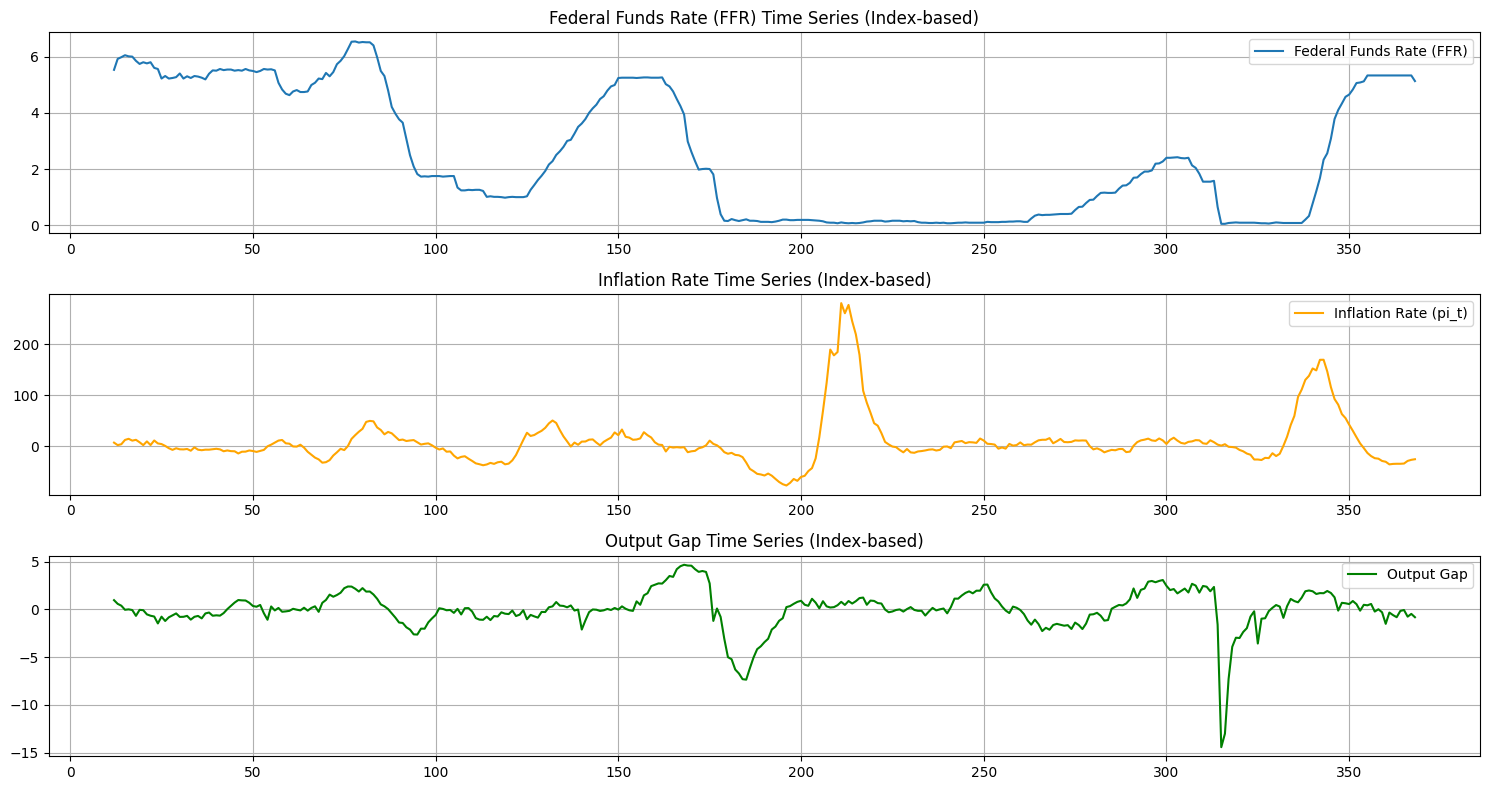

In [10]:
# --- 5. Chow Test 수행 ---
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
# 5.1 검정 시기 결정 (데이터 플로팅)
# 날짜 인덱스가 없으므로, 행 번호(인덱스)를 기준으로 플로팅
plt.figure(figsize=(15, 8))

plt.subplot(3, 1, 1)
plt.plot(data_for_analysis.index, data_for_analysis[ffr_col], label='Federal Funds Rate (FFR)')
plt.title('Federal Funds Rate (FFR) Time Series (Index-based)') # 제목 영어로 변경
plt.grid(True)
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(data_for_analysis.index, data_for_analysis['pi_t'], label='Inflation Rate (pi_t)', color='orange')
plt.title('Inflation Rate Time Series (Index-based)') # 제목 영어로 변경
plt.grid(True)
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(data_for_analysis.index, data_for_analysis['output_gap'], label='Output Gap', color='green')
plt.title('Output Gap Time Series (Index-based)') # 제목 영어로 변경
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()



In [14]:
import statsmodels.formula.api as smf
import statsmodels.api as sm
import pandas as pd
import numpy as np
from scipy.stats import f

# 종속 변수 및 독립 변수 설정
# ffr_col 변수가 정의되어 있어야 합니다.
Y = data_for_analysis[ffr_col]  # 종속 변수: 연방 기금 금리
# 인플레이션 갭과 산출량 격차를 독립 변수로 사용합니다.
X = data_for_analysis[['inflation_gap', 'output_gap']]
X = sm.add_constant(X) # 상수항 추가 (전통적인 테일러 준칙 모델)

# Chow Test를 위한 데이터 준비 (분석 기간은 Y/X로 슬라이싱)
# Y_res, X_res는 전체 분석 기간의 데이터입니다. (이전 코드에서 사용된 Y_res, X_res와 동일)
Y_res = Y
X_res = X
X_res.columns =['const','inflation','output gap'] # 컬럼명 재설정

In [15]:
# 1. 제한된 모형 (Restricted Model) 추정: 구조적 변화를 가정하지 않는 모델
# 전체 기간에 대해 하나의 회귀 모델을 추정합니다.
model_restricted = sm.OLS(Y_res, X_res).fit()
RSS_restricted = model_restricted.ssr # 제한된 모형의 잔차 제곱합 (SSR)

print("--- 제한된 모형 (Restricted Model) 추정 결과 ---")
print(model_restricted.summary())

--- 제한된 모형 (Restricted Model) 추정 결과 ---
                            OLS Regression Results                            
Dep. Variable:           FEDFUNDS.xls   R-squared:                       0.078
Model:                            OLS   Adj. R-squared:                  0.073
Method:                 Least Squares   F-statistic:                     15.07
Date:                Fri, 30 May 2025   Prob (F-statistic):           5.21e-07
Time:                        04:49:56   Log-Likelihood:                -782.31
No. Observations:                 357   AIC:                             1571.
Df Residuals:                     354   BIC:                             1582.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       

In [18]:
# 시각화 결과를 바탕으로 코로나19 정책 변화 시점 결정
# 총 관측치 수 (약 369개월)를 기준으로, 2020년 3월은 데이터 끝에서 약 62개월 전 (2025년 5월 기준)
# 369 - (5년 * 12개월 + 2개월) = 369 - 62 = 307
# 즉, 대략 307번째 인덱스 이후를 코로나19 이후로 간주
# 이 값은 데이터의 실제 기간에 따라 조정이 필요할 수 있습니다.
break_point_index = len(data_for_analysis) - 62 # 대략적인 2020년 3월 시점
chow_breakpoint_index = break_point_index

print(f"\n--- Chow Test 분할 시점 (인덱스): {break_point_index} ---")
print(f"코로나19 이전 기간 관측치 수: {break_point_index}")
print(f"코로나19 이후 기간 관측치 수: {len(data_for_analysis) - break_point_index}")

# 5.2 전통적인 테일러 준칙에 대한 Chow Test
# 데이터 분할
data_pre_covid_trad = data_for_analysis.iloc[:break_point_index].copy()
data_post_covid_trad = data_for_analysis.iloc[break_point_index:].copy()

# 비제한된 모형 (분할된 두 기간 각각)
model_traditional_pre = sm.OLS(data_pre_covid_trad[ffr_col], sm.add_constant(data_pre_covid_trad[['inflation_gap', 'output_gap']])).fit()
model_traditional_post = sm.OLS(data_post_covid_trad[ffr_col], sm.add_constant(data_post_covid_trad[['inflation_gap', 'output_gap']])).fit()




--- Chow Test 분할 시점 (인덱스): 295 ---
코로나19 이전 기간 관측치 수: 295
코로나19 이후 기간 관측치 수: 62


In [19]:
# 3. 비제한된 모형 (Unrestricted Model)을 위한 더미 변수 생성
# 데이터를 reset_index 해야 더미 변수를 인덱스 기준으로 정확히 추가할 수 있습니다.
Y_res_reset = Y_res.reset_index(drop=True)
X_res_reset = X_res.reset_index(drop=True)

# 더미 변수 생성: breakpoint 이후의 데이터에 1, 이전 데이터에 0
X_res_reset['dummy'] = (X_res_reset.index >= chow_breakpoint_index).astype(int)

# 상호작용 항(interaction terms) 생성: 독립 변수와 더미 변수의 곱
# 이는 breakpoint 이후에 각 독립 변수의 계수가 변화하는 것을 모델링합니다.
X_res_reset['interaction_inflation'] = X_res_reset['inflation'] * X_res_reset['dummy']
X_res_reset['interaction_output_gap'] = X_res_reset['output gap'] * X_res_reset['dummy']

# 비제한된 모형에 사용될 독립 변수들 (상수항, 원래 변수들, 더미 변수, 상호작용 항)
X_unrestricted = X_res_reset[['const', 'inflation', 'output gap',
                              'dummy', 'interaction_inflation', 'interaction_output_gap']]

In [21]:
# 4. 비제한된 모형 (Unrestricted Model) 추정
# 더미 변수와 상호작용 항이 포함된 모델을 추정합니다.
model_unrestricted = sm.OLS(Y_res_reset, X_unrestricted).fit()
RSS_unrestricted = model_unrestricted.ssr # 비제한된 모형의 잔차 제곱합 (SSR)

print("\n--- 비제한된 모형 (Unrestricted Model) 추정 결과 ---")
print(model_unrestricted.summary())

# 5. Chow Test F-statistic 계산
N = len(Y_res_reset) # 전체 관측치 수
# num_restrictions: 귀무가설 하에서 제한되는 계수의 수 (즉, 구조적 변화가 없다는 가정)
# 이는 제한된 모델의 파라미터 수와 같습니다 (상수항 포함).
num_restrictions = len(model_restricted.params) # 이 경우 const, inflation, output gap (총 3개)

# num_params_unrestricted: 비제한된 모델의 총 파라미터 수
num_params_unrestricted = len(model_unrestricted.params) # 이 경우 const, inflation, output gap, dummy, interaction_inflation, interaction_output_gap (총 6개)

# F-통계량 계산 공식: F = ((RSS_R - RSS_UR) / num_restrictions) / (RSS_UR / (N - num_params_unrestricted))
F_statistic = ((RSS_restricted - RSS_unrestricted) / num_restrictions) / \
              (RSS_unrestricted / (N - num_params_unrestricted))

# P-value 계산 (F-분포의 생존함수(sf) 사용)
p_value = f.sf(F_statistic, num_restrictions, N - num_params_unrestricted)

print("\n--- Chow Test (더미 변수 방식) 결과 ---")
print(f"USSR (제한된 모형 잔차 제곱합): {RSS_restricted:.4f}")
print(f"USSU (비제한된 모형 잔차 제곱합): {RSS_unrestricted:.4f}")
print(f"Test-statistics (F-statistic): {F_statistic:.4f}")
print(f"P-value: {p_value:.4f}")

# 결과 해석
alpha = 0.05  # 유의수준 5%
if p_value < alpha:
    print("결론: P-value가 유의수준(0.05)보다 작으므로, 귀무가설(구조적 변화 없음)을 기각합니다.")
    print("       코로나19 이전과 이후 정책에 유의미한 구조적 변화가 있었다고 판단합니다.")
else:
    print("결론: P-value가 유의수준(0.05)보다 크므로, 귀무가설(구조적 변화 없음)을 기각하지 못합니다.")
    print("       코로나19 이전과 이후 정책에 유의미한 구조적 변화가 있었다는 증거가 불충분합니다.")




--- 비제한된 모형 (Unrestricted Model) 추정 결과 ---
                            OLS Regression Results                            
Dep. Variable:           FEDFUNDS.xls   R-squared:                       0.086
Model:                            OLS   Adj. R-squared:                  0.073
Method:                 Least Squares   F-statistic:                     6.593
Date:                Fri, 30 May 2025   Prob (F-statistic):           6.99e-06
Time:                        04:52:58   Log-Likelihood:                -780.87
No. Observations:                 357   AIC:                             1574.
Df Residuals:                     351   BIC:                             1597.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------